Выполнили студенты группы ББМО-01-23:
Панков Никита Олегович

Исходный набор данных: Android Malware dataset

In [18]:
variant = 20 % 16 + 1
print(f"Вариант №{variant}")

Вариант №5


In [19]:
import os.path
import re
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub


```
134681 node-246 node status 1077804742 1 successfully
```
Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

- Logid - ID лога, целое число: `(\d*?)`
- Node - Строка, указывающая на каком узле (или компьютере) происходит событие: `(\w+)`
- Component - имя компонента, создавшего запись в логе: `(\w+)`
- State - Сообщение, указывающее на состояние задачи или процесса: `(\w+)`
- Time - Время: `(\w+)`
- Flag - Флаг (метка или индикатор), использующийся для обозначения различных событий или ошибок: `(\d+)`
- Content - Непосредственное содержание записи, все символы до конца строки: `(Command has completed successfully|running|blocked|critical|warning)`

In [21]:
pattern = r'(\d*?)\s(\w+[-]?\d+)\s(\w+)\s(\w+)\s(\w+)\s(\d+)\s(Command has completed successfully|running|blocked|critical|warning)'

In [22]:
# Создание директории для БД, если не существует
os.makedirs("./db/", exist_ok=True)

# Путь к файлу БД
db_path = './db/log-analysis.db'

# Подключение к БД и создание таблицы
with sqlite3.connect(db_path) as connection:
    cursor = connection.cursor()
    cursor.execute("DROP TABLE IF EXISTS logs")
    cursor.execute("""
        CREATE TABLE logs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            Logid int,
            Node text,
            Component text,
            Time text,
            Content text,
            Flag int,
            State text
        )
    """)
    connection.commit()

In [23]:
# Парсинг логов и сохранение записей в БД
with sqlite3.connect(db_path) as connection:
    cursor = connection.cursor()
    cursor.execute("DELETE FROM logs")  # Очистка таблицы

    # Парсинг файла с логами
    with open('./loghub/HPC/HPC_2k.log', 'r', encoding='utf-8') as log_file:
        for line in log_file:
            if (log_match := re.match(pattern, line)):  # Совмещение проверки и присваивания
                values = log_match.groups()  # Получение всех групп за один вызов
                cursor.execute("""
                    INSERT INTO logs (Logid, Node, Component, State, Time, Flag, Content)
                    VALUES (?, ?, ?, ?, ?, ?, ?)""", values)

    connection.commit()  # Сохранение изменений

In [24]:
# Конвертирование даты и времени
with sqlite3.connect(db_path) as connection:
    cursor = connection.cursor()
    cursor.execute("ALTER TABLE logs ADD COLUMN DateTime datetime")
    cursor.execute("UPDATE logs SET DateTime = datetime(Time, 'unixepoch')")
    cursor.execute("ALTER TABLE logs DROP COLUMN Time")
    connection.commit()

In [25]:
# Чтение записей и запись в DataFrame
with sqlite3.connect(db_path) as connection:
    log_df = pd.read_sql_query("SELECT * FROM logs", connection)

log_df

,id,Logid,Node,Component,Content,Flag,State,DateTime
0,1,2566692,1897,boot_cmd,Command has completed successfully,1,success,2004-01-13 11:05:50
1,2,2614626,2001,boot_cmd,Command has completed successfully,1,success,2004-01-22 06:14:05
2,3,178176,2428,boot_cmd,Command has completed successfully,1,success,2004-02-27 15:12:17
3,4,247935,2568,boot_cmd,Command has completed successfully,1,success,2004-03-11 23:52:04
4,5,274749,2685,boot_cmd,Command has completed successfully,1,success,2004-03-18 13:32:04
...,...,...,...,...,...,...,...,...
363,364,449962,gige6,gige,warning,1,temperature,2006-04-10 00:03:27
364,365,465923,gige7,gige,warning,1,temperature,2006-04-21 16:53:13
365,366,466009,gige3,gige,warning,1,temperature,2006-04-22 00:07:12
366,367,480082,gige7,gige,critical,1,temperature,2006-04-27 01:13:18


<ipython-input-31-5a45cfbe23fb>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Применение стиля


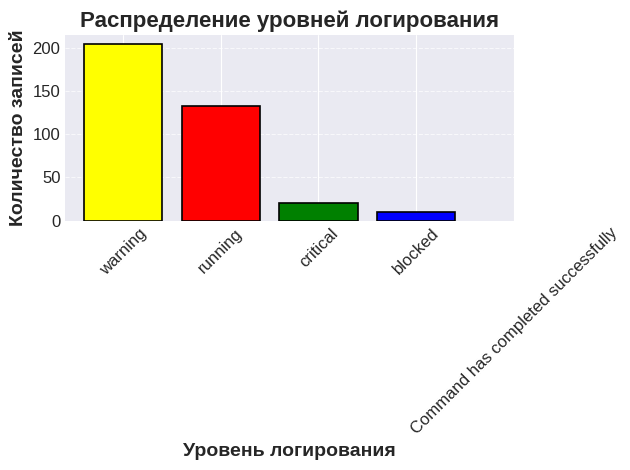

In [31]:
# Построение графика распределения уровней логирования
# подсчёт записей с различными уровнями логирования
log_level_distrib = log_df['Content'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

# более подробные заголовки для графика
verbose_xticks = ["warning", "running", "critical", "blocked", "Command has completed successfully"]
# Построение графика с обновлённым стилем
plt.style.use('seaborn-darkgrid')  # Применение стиля
# Построение столбчатого графика
plt.bar(x, y, color=['yellow', 'red', 'green', 'blue', 'orange'], edgecolor='black', linewidth=1.2)
# Установка меток оси X с наклоном
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=verbose_xticks, rotation=45, fontsize=12)
# Установка меток оси Y
plt.yticks(fontsize=12)
# Заголовки осей
plt.xlabel('Уровень логирования', fontsize=14, fontweight='bold')
plt.ylabel('Количество записей', fontsize=14, fontweight='bold')
# Добавление заголовка графика
plt.title('Распределение уровней логирования', fontsize=16, fontweight='bold')
# Отображение сетки по оси Y
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Отображение графика
plt.tight_layout()  # Оптимизация отступов
plt.show()

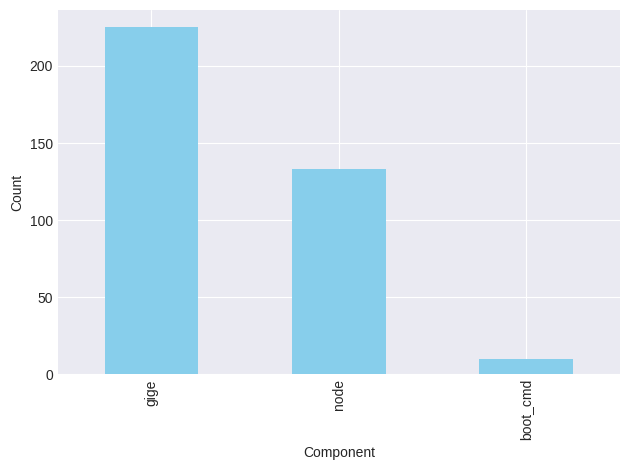

In [33]:
# Построение графика распределения записей по процессам
log_df['Component'].value_counts().plot(kind='bar', xlabel='Component', ylabel='Count', color='skyblue')

plt.tight_layout()
plt.show()

<ipython-input-36-190103a76147>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


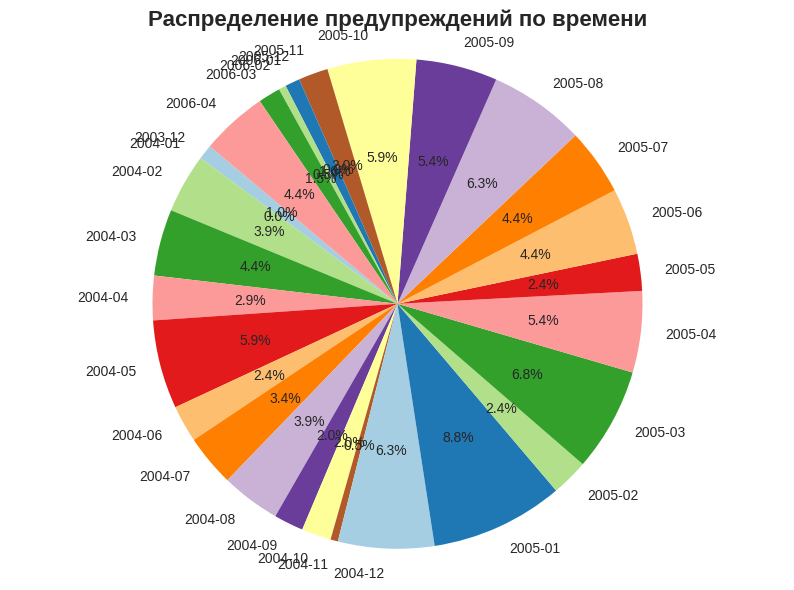

In [36]:
# Построение графика распределения контроля ошибок
warning_count = (log_df[log_df['Content'] == 'warning']
                 .assign(DateTime=lambda df: pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S'))
                 .groupby('DateTime')
                 .size()
                 .resample('M')
                 .sum()
                 .fillna(0))

# Построение круговой диаграммы
plt.figure(figsize=(10, 7))
plt.pie(warning_count, labels=warning_count.index.strftime('%Y-%m'), autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)

# Добавление заголовка
plt.title('Распределение предупреждений по времени', fontsize=16, fontweight='bold')

# Отображение графика
plt.axis('equal')  # Для равных аспектов
plt.show()